In [ ]:
! pip install transformers

In [ ]:
! pip install optuna

In [ ]:
! pip install sentencepiece

In [ ]:
! pip install datasets

In [ ]:
! pip install scikit-learn

In [ ]:
! pip install matplotlib

In [ ]:
! pip install protobuf==3.20.*

In [2]:
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5EncoderModel, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from tqdm.notebook import tqdm

import json

import optuna

In [9]:
all_dialogs = list()
with open("final_big_embedded_good.jsonl", "r") as f:
    dialogs = f.readlines()
    for dialog in dialogs:
        all_dialogs.append(json.loads(dialog))

In [10]:
train, test = train_test_split(all_dialogs, test_size=0.1, shuffle=True)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("allenai/cosmo-xl")

In [41]:
def collate(batch):
        
        change_type = list()
        top_p = list()
        top_k = list()
        typical_p = list()
        temperature = list()

        texts = [' '.join(sample['dialog']) for sample in batch]
        tokenized_texts = tokenizer(texts, return_tensors="pt", padding=True)
        
        for sample in batch:
            change_type.append(sample['change_type'])
            top_p.append(sample['params']['top_p'])
            top_k.append(sample['params']['top_k'])
            typical_p.append(sample['params']['typical_p'])
            temperature.append(sample['params']['temperature'])

        change_type = torch.tensor(change_type)   
        top_p = torch.tensor(top_p)
        top_k = torch.tensor(top_k)
        typical_p = torch.tensor(typical_p)
        temperature = torch.tensor(temperature)

        return tokenized_texts, change_type, top_p, top_k, typical_p, temperature

In [13]:
train_dataloader = DataLoader(train, batch_size=32, shuffle=True, collate_fn=collate)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True, collate_fn=collate)

In [27]:
def tensor_masking(tensor: Tensor, mask: Tensor, value: float = 0.0) -> Tensor:
    return tensor.masked_fill((~(mask.bool())).unsqueeze(-1), value)

class MaskedPooling(nn.Module):

    def __init__(
        self,
        dim: int = 1,
    ):
        super().__init__()
            
        self.dim = dim

        self.mask_value = 0.0

    def forward(self, tensor: Tensor, pad_mask: Tensor) -> Tensor:
        lengths = pad_mask.sum(self.dim).float()

        tensor = tensor_masking(tensor, pad_mask, value=self.mask_value)

        scaling = tensor.size(self.dim) / lengths

        scaling = scaling.masked_fill(lengths == 0, 1.0).unsqueeze(-1)

        tensor = tensor.mean(self.dim)

        tensor *= scaling

        return tensor

In [ ]:
model = T5EncoderModel.from_pretrained("allenai/cosmo-xl")

In [12]:
for p in model.parameters():
    p.requires_grad = False

model.eval()

T5EncoderModel(
  (shared): Embedding(32128, 2048)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 2048)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=2048, out_features=2048, bias=False)
              (k): Linear(in_features=2048, out_features=2048, bias=False)
              (v): Linear(in_features=2048, out_features=2048, bias=False)
              (o): Linear(in_features=2048, out_features=2048, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
              (wi_1): Linear(in_features=2048, out_features=5120, bias=False)
              (wo):

In [28]:
pool = MaskedPooling()

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [30]:
model = model.to(device)

Сохранение всех батчей для более быстрого тестирования параметров и обучения модели

In [21]:
dataset_train = list()
dataset_test = list()

for tokenized, change_type, top_p, top_k, typical_p, temperature in train_dataloader:

    tokenized = tokenized.to(device)
    change_type = change_type.to(device)
    top_p = top_p.to(device)
    top_k = top_k.to(device)
    typical_p = typical_p.to(device)
    temperature = temperature.to(device)

    with torch.no_grad():
        model_output = model(**tokenized)

    context_embedding = pool(model_output.last_hidden_state, tokenized.attention_mask)

    dataset_train.append({"embedding": context_embedding.cpu().numpy().tolist(),
                          "change_type": change_type.cpu().numpy().tolist(),
                          "top_p": top_p.cpu().numpy().tolist(),
                          "top_k": top_k.cpu().numpy().tolist(),
                          "typical_p": typical_p.cpu().numpy().tolist(),
                          "temperature": temperature.cpu().numpy().tolist()})
    
for tokenized, change_type, top_p, top_k, typical_p, temperature in test_dataloader:

    tokenized = tokenized.to(device)
    change_type = change_type.to(device)
    top_p = top_p.to(device)
    top_k = top_k.to(device)
    typical_p = typical_p.to(device)
    temperature = temperature.to(device)

    with torch.no_grad():
        model_output = model(**tokenized)

    context_embedding = pool(model_output.last_hidden_state, tokenized.attention_mask)

    dataset_test.append({"embedding": context_embedding.cpu().numpy().tolist(),
                         "change_type": change_type.cpu().numpy().tolist(),
                         "top_p": top_p.cpu().numpy().tolist(),
                         "top_k": top_k.cpu().numpy().tolist(),
                         "typical_p": typical_p.cpu().numpy().tolist(),
                         "temperature": temperature.cpu().numpy().tolist()})

In [22]:
output_file = open('dataset_train.jsonl', 'w', encoding='utf-8')
for dic in dataset_train:
    json.dump(dic, output_file) 
    output_file.write("\n")

In [23]:
output_file = open('dataset_test.jsonl', 'w', encoding='utf-8')
for dic in dataset_test:
    json.dump(dic, output_file) 
    output_file.write("\n")

In [5]:
dataset_train = list()
with open('dataset_train.jsonl', 'r', encoding='utf-8') as f:
    for dialog in tqdm(f.readlines()):
        dialog = json.loads(dialog)
        dataset_train.append(dialog)

  0%|          | 0/304 [00:00<?, ?it/s]

In [6]:
dataset_test = list()
with open('dataset_test.jsonl', 'r', encoding='utf-8') as f:
    for dialog in tqdm(f.readlines()):
        dialog = json.loads(dialog)
        dataset_test.append(dialog)

  0%|          | 0/34 [00:00<?, ?it/s]

In [140]:
class GenerationParameterClassifierWithType(nn.Module):
        
    def __init__(self, embedding_dim=512, inner_dim=128, type_dim=128, use_relu=True):
        super().__init__()
        
        self.input_layer = nn.Linear(embedding_dim, inner_dim)

        self.type_classifier = torch.nn.Linear(inner_dim, 3)
        self.type_embeddings = nn.Embedding(3, type_dim)
        
        if use_relu:
            self.top_p_classifier = nn.Sequential(nn.Linear(inner_dim + type_dim, inner_dim), nn.ReLU(), nn.Linear(inner_dim, 20))
            self.typical_p_classifier = nn.Sequential(nn.Linear(inner_dim + type_dim, inner_dim), nn.ReLU(), nn.Linear(inner_dim, 20))
            self.top_k_classifier = nn.Sequential(nn.Linear(inner_dim + type_dim * 3, inner_dim), nn.ReLU(), nn.Linear(inner_dim, 11))
            self.temperature_classifier = nn.Sequential(nn.Linear(inner_dim + type_dim * 4, inner_dim), nn.ReLU(), nn.Linear(inner_dim, 24))
        else:
            self.top_p_classifier = nn.Linear(inner_dim + type_dim, 20)
            self.typical_p_classifier = nn.Linear(inner_dim + type_dim, 20)
            self.top_k_classifier = nn.Linear(inner_dim + type_dim * 3, 11)
            self.temperature_classifier = nn.Linear(inner_dim + type_dim * 4, 24)   
        
        
        self.top_p_embeddings = nn.Embedding(20, type_dim)
        self.typical_p_embeddings = nn.Embedding(20, type_dim)
        self.top_k_embeddings = nn.Embedding(11, type_dim)

      
    def forward_training(self, context_embeddings, change_type, top_p, top_k, typical_p):

        x = self.input_layer(context_embeddings)

        change_type_predictions = self.type_classifier(x)

        for_top_p_embeddings = torch.cat((x, self.type_embeddings(change_type)), -1)
        
        top_p_predictions = self.top_p_classifier(for_top_p_embeddings)
        typical_p_predictions = self.typical_p_classifier(for_top_p_embeddings)
        
        for_top_k_embeddings = torch.cat((for_top_p_embeddings,
                                          self.top_p_embeddings(top_p),
                                          self.typical_p_embeddings(typical_p)), -1)
        
        top_k_predictions = self.top_k_classifier(for_top_k_embeddings)
        
        for_temp_embeddings = torch.cat((for_top_k_embeddings,
                                         self.top_k_embeddings(top_k)), -1)
        
        temp_predictions = self.temperature_classifier(for_temp_embeddings)

        return change_type_predictions, top_p_predictions, typical_p_predictions, top_k_predictions, temp_predictions
        
        
    def forward(self, context_embeddings):
        # argmax

        x = self.input_layer(context_embeddings)

        change_type_predictions = self.type_classifier(x)

        change_type_class = change_type_predictions.argmax(-1)

        for_top_p_embeddings = torch.cat((x, self.type_embeddings(change_type_class)), -1)

        top_p_predictions = self.top_p_classifier(for_top_p_embeddings)
        top_p_class = top_p_predictions.argmax(-1)
        typical_p_predictions = self.typical_p_classifier(for_top_p_embeddings)
        typical_p_class = typical_p_predictions.argmax(-1)
        
        for_top_k_embeddings = torch.cat((for_top_p_embeddings,
                                          self.top_p_embeddings(top_p_class),
                                          self.typical_p_embeddings(typical_p_class)), -1)                                         
        
        top_k_predictions = self.top_k_classifier(for_top_k_embeddings)
        top_k_class = top_k_predictions.argmax(-1)
        
        for_temp_embeddings = torch.cat((for_top_k_embeddings,
                                         self.top_k_embeddings(top_k_class)), -1)
        
        temp_predictions = self.temperature_classifier(for_temp_embeddings)
        
        return change_type_predictions, top_p_predictions, typical_p_predictions, top_k_predictions, temp_predictions

# Оптимизация параметров при помощи optuna
Параметры оптимизировались для варианта модели с обработкой типа сэмплирования *change_type*

In [153]:
def build_model(params):
    
    classifier = GenerationParameterClassifierWithType(embedding_dim=model.config.d_model,
                                                       inner_dim=params['inner_dim'],
                                                       type_dim=params['type_dim'],
                                                       use_relu=params['use_relu'])
    
    return classifier

In [154]:
def train_and_evaluate(params, classifier):
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss(reduction='none')
    opt = torch.optim.Adam(classifier.parameters(), lr=params['learning_rate'])
    
    if use_cuda:

        classifier = classifier.cuda()
        criterion = criterion.cuda()
        
    for epoch_num in range(EPOCHS):

        train_losses = list()

        for batch in dataset_train:

            context_embedding = torch.Tensor(np.asarray(batch['embedding'])).to(device)
            change_type = torch.LongTensor(np.asarray(batch['change_type'])).to(device)
            top_p = torch.LongTensor(np.asarray(batch['top_p'])).to(device)
            top_k = torch.LongTensor(np.asarray(batch['top_k'])).to(device)
            typical_p = torch.LongTensor(np.asarray(batch['typical_p'])).to(device)
            temperature = torch.LongTensor(np.asarray(batch['temperature'])).to(device)

            opt.zero_grad()
            
            pred_change_type, pred_top_p, pred_typical_p, pred_top_k, pred_temp = classifier.forward_training(context_embedding, change_type, top_p, top_k, typical_p)
            
            mask_top_p = change_type == 0
            mask_typical_p = change_type == 1
            
            loss_change_type = criterion(pred_change_type, change_type).mean()
            loss_top_p = criterion(pred_top_p, top_p)[~mask_typical_p].mean()
            loss_top_k = criterion(pred_top_k, top_k)[~mask_typical_p].mean()
            loss_typical_p = criterion(pred_typical_p, typical_p)[~mask_top_p].mean()
            loss_temp = criterion(pred_temp, temperature).mean()
            
            if loss_top_p.isnan():
                loss = torch.mean(torch.stack([loss_change_type, loss_typical_p, loss_temp]))
            elif loss_typical_p.isnan():
                loss = torch.mean(torch.stack([loss_change_type, loss_top_p, loss_top_k, loss_temp]))
            else:
                loss = torch.mean(torch.stack([loss_change_type, loss_top_p, loss_top_k, loss_typical_p, loss_temp]))
            
            train_losses.append(loss.item())

            loss.backward()
            opt.step()
            classifier.zero_grad()
            
        test_losses = list()

        with torch.no_grad():

            for batch in dataset_test:

                context_embedding = torch.Tensor(np.asarray(batch['embedding'])).to(device)
                change_type = torch.LongTensor(np.asarray(batch['change_type'])).to(device)
                top_p = torch.LongTensor(np.asarray(batch['top_p'])).to(device)
                top_k = torch.LongTensor(np.asarray(batch['top_k'])).to(device)
                typical_p = torch.LongTensor(np.asarray(batch['typical_p'])).to(device)
                temperature = torch.LongTensor(np.asarray(batch['temperature'])).to(device)

                pred_change_type, pred_top_p, pred_typical_p, pred_top_k, pred_temp = classifier(context_embedding)
                
                change_type_class = pred_change_type.argmax(-1)
                            
                mask_top_p = change_type_class == 0
                mask_typical_p = change_type_class == 1
                
                loss_change_type = criterion(pred_change_type, change_type).mean()
                loss_top_p = criterion(pred_top_p, top_p)[~mask_typical_p].mean()
                loss_top_k = criterion(pred_top_k, top_k)[~mask_typical_p].mean()
                loss_typical_p = criterion(pred_typical_p, typical_p)[~mask_top_p].mean()
                loss_temp = criterion(pred_temp, temperature).mean()
                
                if loss_top_p.isnan():
                    loss = torch.mean(torch.stack([loss_change_type, loss_typical_p, loss_temp]))
                elif loss_typical_p.isnan():
                    loss = torch.mean(torch.stack([loss_change_type, loss_top_p, loss_top_k, loss_temp]))
                else:
                    loss = torch.mean(torch.stack([loss_change_type, loss_top_p, loss_top_k, loss_typical_p, loss_temp]))
                
                test_losses.append(loss.item())

    return np.mean(test_losses)

In [159]:
def objective(trial):
    
    params = {
              'learning_rate': trial.suggest_categorical('learning_rate', [0.001, 0.0005, 0.0001, 0.00005, 0.00001]),
              'inner_dim': trial.suggest_categorical("inner_dim", [64, 128, 264, 512]),
              'type_dim': trial.suggest_categorical("type_dim", [32, 64, 128]),
              'use_relu': trial.suggest_categorical("use_relu", [True, False]),               
              }
    
    classifier = build_model(params)
    
    cross_entropy_loss = train_and_evaluate(params, classifier)
    
    return cross_entropy_loss

In [160]:
EPOCHS = 30

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2023-06-03 14:05:08,189] A new study created in memory with name: no-name-4f080bef-4729-4c75-8de4-bdb5985f2a2b
[I 2023-06-03 14:06:50,045] Trial 0 finished with value: 2.3946448494406307 and parameters: {'learning_rate': 0.0001, 'inner_dim': 64, 'type_dim': 64, 'use_relu': True}. Best is trial 0 with value: 2.3946448494406307.
[I 2023-06-03 14:08:15,415] Trial 1 finished with value: 2.374828773386338 and parameters: {'learning_rate': 5e-05, 'inner_dim': 512, 'type_dim': 64, 'use_relu': False}. Best is trial 1 with value: 2.374828773386338.
[I 2023-06-03 14:09:46,543] Trial 2 finished with value: 3.482441179892596 and parameters: {'learning_rate': 0.001, 'inner_dim': 264, 'type_dim': 32, 'use_relu': False}. Best is trial 1 with value: 2.374828773386338.
[I 2023-06-03 14:11:16,412] Trial 3 finished with value: 2.3401815751019646 and parameters: {'learning_rate': 1e-05, 'inner_dim': 64, 'type_dim': 128, 'use_relu': False}. Best is trial 3 with value: 2.3401815751019646.
[I 2023-06-03 1

In [161]:
study.trials_dataframe().sort_values('value').head()

,number,value,datetime_start,datetime_complete,duration,params_inner_dim,params_learning_rate,params_type_dim,params_use_relu,state
27,27,2.313639,2023-06-03 14:49:36.000624,2023-06-03 14:51:26.620443,0 days 00:01:50.619819,264,0.00001,32,True,COMPLETE
23,23,2.315411,2023-06-03 14:42:50.669079,2023-06-03 14:44:29.059881,0 days 00:01:38.390802,264,0.00001,32,False,COMPLETE
28,28,2.315558,2023-06-03 14:51:26.621890,2023-06-03 14:53:16.012399,0 days 00:01:49.390509,264,0.00001,32,True,COMPLETE
14,14,2.318508,2023-06-03 14:28:06.152215,2023-06-03 14:29:43.479407,0 days 00:01:37.327192,264,0.00001,32,False,COMPLETE
26,26,2.318630,2023-06-03 14:47:45.380615,2023-06-03 14:49:35.999237,0 days 00:01:50.618622,264,0.00001,128,True,COMPLETE


In [162]:
study.best_params

{'learning_rate': 1e-05, 'inner_dim': 264, 'type_dim': 32, 'use_relu': True}

# С лучшими параметрами

## Без типа

In [7]:
class GenerationParameterClassifier(nn.Module):
        
    def __init__(self, embedding_dim=512, inner_dim=128, type_dim=128, use_relu=True):
        super().__init__()
        
        self.input_layer = nn.Linear(embedding_dim, inner_dim)

        if use_relu:
            self.top_p_classifier = nn.Sequential(nn.Linear(inner_dim, inner_dim), nn.ReLU(), nn.Linear(inner_dim, 20))
            self.typical_p_classifier = nn.Sequential(nn.Linear(inner_dim, inner_dim), nn.ReLU(), nn.Linear(inner_dim, 20))
            self.top_k_classifier = nn.Sequential(nn.Linear(inner_dim + type_dim * 2, inner_dim), nn.ReLU(), nn.Linear(inner_dim, 11))
            self.temperature_classifier = nn.Sequential(nn.Linear(inner_dim + type_dim * 3, inner_dim), nn.ReLU(), nn.Linear(inner_dim, 24))
        else:
            self.top_p_classifier = nn.Linear(inner_dim, 20)
            self.typical_p_classifier = nn.Linear(inner_dim, 20)
            self.top_k_classifier = nn.Linear(inner_dim + type_dim * 2, 11)
            self.temperature_classifier = nn.Linear(inner_dim + type_dim * 3, 24)        
        
        
        self.top_p_embeddings = nn.Embedding(20, type_dim)
        self.typical_p_embeddings = nn.Embedding(20, type_dim)
        self.top_k_embeddings = nn.Embedding(11, type_dim)

      
    def forward_training(self, context_embeddings, top_p, top_k, typical_p):

        x = self.input_layer(context_embeddings)
        
        for_top_p_embeddings = x
        
        top_p_predictions = self.top_p_classifier(for_top_p_embeddings)
        typical_p_predictions = self.typical_p_classifier(for_top_p_embeddings)
        
        for_top_k_embeddings = torch.cat((for_top_p_embeddings,
                                          self.top_p_embeddings(top_p),
                                          self.typical_p_embeddings(typical_p)), -1)
        
        top_k_predictions = self.top_k_classifier(for_top_k_embeddings)
        
        for_temp_embeddings = torch.cat((for_top_k_embeddings,
                                         self.top_k_embeddings(top_k)), -1)
        
        temp_predictions = self.temperature_classifier(for_temp_embeddings)

        return top_p_predictions, typical_p_predictions, top_k_predictions, temp_predictions
        
        
    def forward(self, context_embeddings):
        # argmax

        x = self.input_layer(context_embeddings)
        
        for_top_p_embeddings = x

        top_p_predictions = self.top_p_classifier(for_top_p_embeddings)
        top_p_class = top_p_predictions.argmax(-1)
        typical_p_predictions = self.typical_p_classifier(for_top_p_embeddings)
        typical_p_class = typical_p_predictions.argmax(-1)
        
        for_top_k_embeddings = torch.cat((for_top_p_embeddings,
                                          self.top_p_embeddings(top_p_class),
                                          self.typical_p_embeddings(typical_p_class)), -1)                                         
        
        top_k_predictions = self.top_k_classifier(for_top_k_embeddings)
        top_k_class = top_k_predictions.argmax(-1)
        
        for_temp_embeddings = torch.cat((for_top_k_embeddings,
                                         self.top_k_embeddings(top_k_class)), -1)
        
        temp_predictions = self.temperature_classifier(for_temp_embeddings)
        
        return top_p_predictions, typical_p_predictions, top_k_predictions, temp_predictions

In [14]:
classifier = GenerationParameterClassifier(embedding_dim=model.config.d_model,
                                           inner_dim=264,
                                           type_dim=32,
                                           use_relu=True)

In [15]:
learning_rate = 0.00001

In [16]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [17]:
classifier = classifier.to(device)
criterion = criterion.to(device)

In [18]:
count_dialogs = (len(dataset_train) - 1) * 32 + len(dataset_train[-1]['top_p'])

In [19]:
NUM_EPOCHS = 30

train_loss = []
test_loss = []

epoch_train_loss = []
epoch_test_loss = []

for n_epoch in range(NUM_EPOCHS):

    train_losses = []
    test_losses = []
    test_preds = {'top_p': list(), 'top_k': list(), 'typical_p': list(), 'temperature': list()}
    test_targets = {'top_p': list(), 'top_k': list(), 'typical_p': list(), 'temperature': list()}
    
    progress_bar = tqdm(total=count_dialogs, desc='Epoch {}'.format(n_epoch + 1))

    for batch in dataset_train:

        context_embedding = torch.Tensor(np.asarray(batch['embedding'])).to(device)
        top_p = torch.LongTensor(np.asarray(batch['top_p'])).to(device)
        top_k = torch.LongTensor(np.asarray(batch['top_k'])).to(device)
        typical_p = torch.LongTensor(np.asarray(batch['typical_p'])).to(device)
        temperature = torch.LongTensor(np.asarray(batch['temperature'])).to(device)

        opt.zero_grad()

        pred_top_p, pred_typical_p, pred_top_k, pred_temp = classifier.forward_training(context_embedding, top_p, top_k, typical_p)

        loss_top_p = criterion(pred_top_p, top_p)
        loss_top_k = criterion(pred_top_k, top_k)
        loss_typical_p = criterion(pred_typical_p, typical_p)
        loss_temp = criterion(pred_temp, temperature)
        
        loss = torch.mean(torch.stack([loss_top_p, loss_top_k, loss_typical_p, loss_temp]))
        
        train_losses.append(loss.item())

        loss.backward()
        opt.step()
        classifier.zero_grad()
            
        train_loss.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(train_loss[-100:]))

        progress_bar.update(top_p.shape[0])

    progress_bar.close()

    with torch.no_grad():

        for batch in dataset_test:

            context_embedding = torch.Tensor(np.asarray(batch['embedding'])).to(device)
            top_p = torch.LongTensor(np.asarray(batch['top_p'])).to(device)
            top_k = torch.LongTensor(np.asarray(batch['top_k'])).to(device)
            typical_p = torch.LongTensor(np.asarray(batch['typical_p'])).to(device)
            temperature = torch.LongTensor(np.asarray(batch['temperature'])).to(device)

            pred_top_p, pred_typical_p, pred_top_k, pred_temp = classifier(context_embedding)

            loss_top_p = criterion(pred_top_p, top_p)
            loss_top_k = criterion(pred_top_k, top_k)
            loss_typical_p = criterion(pred_typical_p, typical_p)
            loss_temp = criterion(pred_temp, temperature)

            loss = torch.mean(torch.stack([loss_top_p, loss_top_k, loss_typical_p, loss_temp]))

            test_losses.append(loss.item())
            
            test_loss.append(loss.item())
            
            test_preds['top_p'].append(pred_top_p.argmax(-1).cpu().numpy())
            test_preds['top_k'].append(pred_top_k.argmax(-1).cpu().numpy())
            test_preds['typical_p'].append(pred_typical_p.argmax(-1).cpu().numpy())
            test_preds['temperature'].append(pred_temp.argmax(-1).cpu().numpy())

            test_targets['top_p'].append(top_p.cpu().numpy())
            test_targets['top_k'].append(top_k.cpu().numpy())
            test_targets['typical_p'].append(typical_p.cpu().numpy())
            test_targets['temperature'].append(temperature.cpu().numpy())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    epoch_train_loss.append(np.mean(train_losses))
    epoch_test_loss.append(mean_test_loss)

    test_preds_top_p = np.concatenate(test_preds['top_p']).squeeze()
    test_preds_top_k = np.concatenate(test_preds['top_k']).squeeze()
    test_preds_typical_p = np.concatenate(test_preds['typical_p']).squeeze()
    test_preds_temp = np.concatenate(test_preds['temperature']).squeeze()
    
    f1_top_p = f1_score(np.concatenate(test_targets['top_p']), test_preds_top_p, average='weighted')
    f1_top_k = f1_score(np.concatenate(test_targets['top_k']), test_preds_top_k, average='weighted')
    f1_typical_p = f1_score(np.concatenate(test_targets['typical_p']), test_preds_typical_p, average='weighted')
    f1_temp = f1_score(np.concatenate(test_targets['temperature']), test_preds_temp, average='weighted')

    f1 = np.mean([f1_top_p, f1_top_k, f1_typical_p, f1_temp])

    print('Test: f1 - {:.3f} (top_p: {:.3f}, top_k: {:.3f}, typical_p: {:.3f}, temperature: {:.3f})'.format(f1, f1_top_p, f1_top_k, f1_typical_p, f1_temp))

Epoch 1:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.824, test - 2.748
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 2:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.580, test - 2.461
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 3:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.334, test - 2.375
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 4:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.281, test - 2.363
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 5:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.263, test - 2.358
Test: f1 - 0.224 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.011)


Epoch 6:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.252, test - 2.357
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 7:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.245, test - 2.357
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 8:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.240, test - 2.358
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 9:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.236, test - 2.359
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 10:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.233, test - 2.360
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 11:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.231, test - 2.361
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 12:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.229, test - 2.362
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 13:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.228, test - 2.363
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 14:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.226, test - 2.363
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 15:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.225, test - 2.363
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 16:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.224, test - 2.363
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 17:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.223, test - 2.363
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 18:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.222, test - 2.362
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 19:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.222, test - 2.362
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 20:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.221, test - 2.361
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 21:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.220, test - 2.361
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 22:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.219, test - 2.360
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 23:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.219, test - 2.360
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.007)


Epoch 24:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.218, test - 2.359
Test: f1 - 0.223 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.009)


Epoch 25:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.217, test - 2.358
Test: f1 - 0.224 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.010)


Epoch 26:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.217, test - 2.358
Test: f1 - 0.224 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.011)


Epoch 27:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.216, test - 2.357
Test: f1 - 0.224 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.011)


Epoch 28:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.215, test - 2.357
Test: f1 - 0.224 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.012)


Epoch 29:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.215, test - 2.356
Test: f1 - 0.224 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.013)


Epoch 30:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.214, test - 2.356
Test: f1 - 0.225 (top_p: 0.338, top_k: 0.337, typical_p: 0.210, temperature: 0.013)


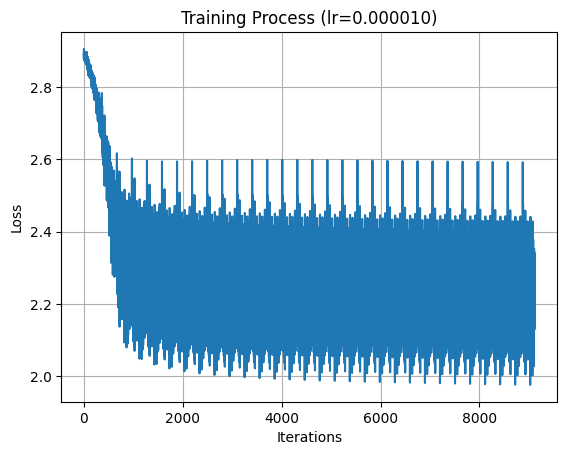

In [20]:
plt.title('Training Process (lr=%f)' % learning_rate)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(train_loss)

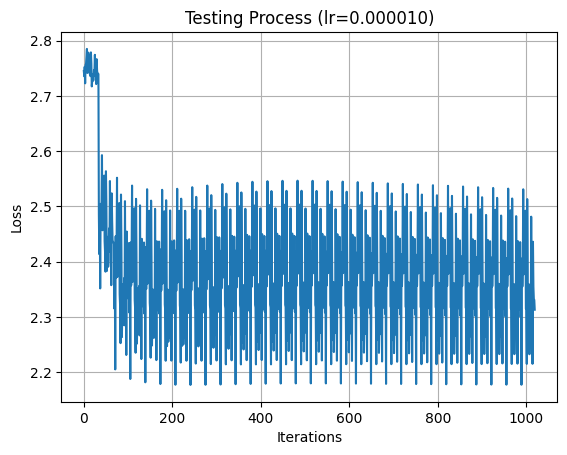

In [21]:
plt.title('Testing Process (lr=%f)' % learning_rate)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(test_loss)

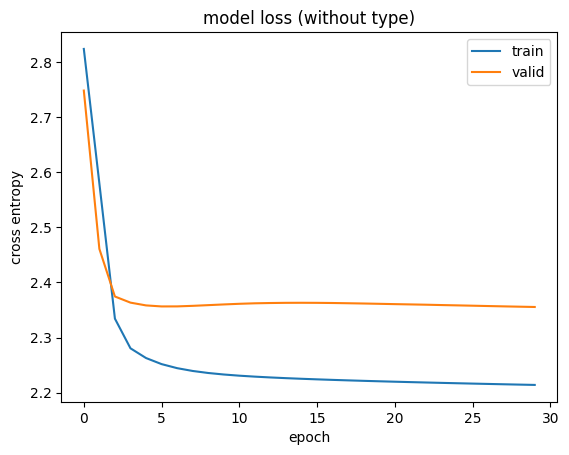

In [22]:
plt.plot(epoch_train_loss)
plt.plot(epoch_test_loss)
plt.title('model loss (without type)')
plt.ylabel('cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [115]:
torch.save(classifier.state_dict(), 'classifier_model.pt')

In [38]:
classifier = GenerationParameterClassifier(embedding_dim=model.config.d_model, inner_dim=264, type_dim=32, use_relu=True)
classifier.load_state_dict(torch.load('classifier_model.pt'))
classifier.eval()

GenerationParameterClassifier(
  (input_layer): Linear(in_features=2048, out_features=264, bias=True)
  (type_classifier): Linear(in_features=264, out_features=3, bias=True)
  (type_embeddings): Embedding(3, 32)
  (top_p_classifier): Sequential(
    (0): Linear(in_features=296, out_features=264, bias=True)
    (1): ReLU()
    (2): Linear(in_features=264, out_features=20, bias=True)
  )
  (typical_p_classifier): Sequential(
    (0): Linear(in_features=296, out_features=264, bias=True)
    (1): ReLU()
    (2): Linear(in_features=264, out_features=20, bias=True)
  )
  (top_k_classifier): Sequential(
    (0): Linear(in_features=360, out_features=264, bias=True)
    (1): ReLU()
    (2): Linear(in_features=264, out_features=11, bias=True)
  )
  (temperature_classifier): Sequential(
    (0): Linear(in_features=392, out_features=264, bias=True)
    (1): ReLU()
    (2): Linear(in_features=264, out_features=24, bias=True)
  )
  (top_p_embeddings): Embedding(20, 32)
  (typical_p_embeddings): Embe

In [ ]:
classifier.to(device)

### Предсказание на тестовой выборке

In [23]:
new = list()
with open("emp_test.jsonl", "r") as g:
    dialogs = g.readlines()
    for dialog in dialogs:
        dialog = json.loads(dialog)
        if len(dialog['dialog']) == 1:
            continue
        new.append(dialog)

In [24]:
def collate_test(batch):

        texts = [' '.join(sample['dialog']) for sample in batch]
        tokenized_texts = tokenizer(texts, return_tensors="pt", padding=True)

        return tokenized_texts

In [25]:
new_dataloader = DataLoader(new, batch_size=32, shuffle=False, collate_fn=collate_test)

In [31]:
new_preds = {'top_p': list(), 'top_k': list(), 'typical_p': list(), 'temperature': list()}

for tokenized in tqdm(new_dataloader):

    tokenized = tokenized.to(device)

    with torch.no_grad():
        model_output = model(**tokenized)

        context_embedding = pool(model_output.last_hidden_state, tokenized.attention_mask)

        pred_top_p, pred_typical_p, pred_top_k, pred_temp = classifier(context_embedding)

    new_preds['top_p'].append(pred_top_p.argmax(-1).cpu().numpy())
    new_preds['top_k'].append(pred_top_k.argmax(-1).cpu().numpy())
    new_preds['typical_p'].append(pred_typical_p.argmax(-1).cpu().numpy())
    new_preds['temperature'].append(pred_temp.argmax(-1).cpu().numpy())

  0%|          | 0/220 [00:00<?, ?it/s]

In [32]:
data = pd.DataFrame(new)

In [33]:
data['top_p'] = np.concatenate(new_preds['top_p'])
data['top_k'] = np.concatenate(new_preds['top_k'])
data['typical_p'] = np.concatenate(new_preds['typical_p'])
data['temperature'] = np.concatenate(new_preds['temperature'])
data['do_sample'] = True

In [34]:
top_k_range = [5, 25, 50, 75, 100, 150, 250, 350, 500, 750, 1000]

top_p_range = np.arange(0.05, 1.01, 0.05)

typical_p_range = top_p_range

temperature_range = np.arange(0.05, 1.21, 0.05)

In [35]:
top_p_vocab = {value: round(i, 2) for i, value in zip(top_p_range, range(len(top_p_range)))}
typical_p_vocab = {value: round(i, 2) for i, value in zip(typical_p_range, range(len(typical_p_range)))}
top_k_vocab = {value: i for i, value in zip(top_k_range, range(len(top_k_range)))}
temperature_vocab = {value: round(i, 2) for i, value in zip(temperature_range, range(len(temperature_range)))}

In [36]:
data['top_p'] = data['top_p'].map(top_p_vocab)
data['top_k'] = data['top_k'].map(top_k_vocab)
data['typical_p'] = data['typical_p'].map(typical_p_vocab)
data['temperature'] = data['temperature'].map(temperature_vocab)

In [37]:
columns = ['top_p', 'top_k', 'typical_p', 'temperature', 'do_sample']
data['pred_params'] = data[columns].to_dict(orient='records')
data = data.drop(columns=columns)

In [38]:
data = data.drop(columns=['predicted_answers'])

In [39]:
data.head()

,dialog,real_answer,pred_params
0,[I can't believe the bottom of the bag ripped ...,Even worse. I'm so sorry. What did you do inst...,"{'top_p': 1.0, 'top_k': 50, 'typical_p': 1.0, ..."
1,"[Two years ago I got diagnosed with MS, What'd...","Well,I pray you get through it","{'top_p': 1.0, 'top_k': 50, 'typical_p': 1.0, ..."
2,[I feel very protective of the new dog I got i...,None,"{'top_p': 1.0, 'top_k': 50, 'typical_p': 1.0, ..."
3,[I took my co-workers phone charger and brough...,Thats sickening. Don't steal stuff or you dese...,"{'top_p': 1.0, 'top_k': 50, 'typical_p': 1.0, ..."
4,[I have a big exam coming up. I have attended ...,I feel like it. I am going to get together wit...,"{'top_p': 1.0, 'top_k': 50, 'typical_p': 1.0, ..."


In [40]:
data.pred_params.astype('str').value_counts()

pred_params
{'top_p': 1.0, 'top_k': 50, 'typical_p': 1.0, 'temperature': 1.15, 'do_sample': True}    5712
{'top_p': 1.0, 'top_k': 50, 'typical_p': 1.0, 'temperature': 1.1, 'do_sample': True}     1314
Name: count, dtype: int64

In [139]:
data[['dialog', 'pred_params']].to_json('final_embedded_pred_params_without_type.jsonl', orient='records', lines=True)

## С типом

In [141]:
classifier = GenerationParameterClassifierWithType(embedding_dim=model.config.d_model,
                                                   inner_dim=264,
                                                   type_dim=32,
                                                   use_relu=True)

In [142]:
learning_rate = 0.00001

In [143]:
criterion = nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [144]:
classifier = classifier.to(device)
criterion = criterion.to(device)

In [145]:
count_dialogs = (len(dataset_train) - 1) * 32 + len(dataset_train[-1]['top_p'])

In [146]:
NUM_EPOCHS = 30

train_loss = []
test_loss = []

epoch_train_loss = []
epoch_test_loss = []

for n_epoch in range(NUM_EPOCHS):

    train_losses = []
    test_losses = []
    test_preds = {'top_p': list(), 'top_k': list(), 'typical_p': list(), 'temperature': list()}
    test_targets = {'top_p': list(), 'top_k': list(), 'typical_p': list(), 'temperature': list()}
    
    progress_bar = tqdm(total=count_dialogs, desc='Epoch {}'.format(n_epoch + 1))

    for batch in dataset_train:

        context_embedding = torch.Tensor(np.asarray(batch['embedding'])).to(device)
        change_type = torch.LongTensor(np.asarray(batch['change_type'])).to(device)
        top_p = torch.LongTensor(np.asarray(batch['top_p'])).to(device)
        top_k = torch.LongTensor(np.asarray(batch['top_k'])).to(device)
        typical_p = torch.LongTensor(np.asarray(batch['typical_p'])).to(device)
        temperature = torch.LongTensor(np.asarray(batch['temperature'])).to(device)

        opt.zero_grad()

        pred_change_type, pred_top_p, pred_typical_p, pred_top_k, pred_temp = classifier.forward_training(context_embedding, change_type, top_p, top_k, typical_p)
        
        
        mask_top_p = change_type == 0
        mask_typical_p = change_type == 1

        loss_change_type = criterion(pred_change_type, change_type).mean()
        loss_top_p = criterion(pred_top_p, top_p)[~mask_typical_p].mean()
        loss_top_k = criterion(pred_top_k, top_k)[~mask_typical_p].mean()
        loss_typical_p = criterion(pred_typical_p, typical_p)[~mask_top_p].mean()
        loss_temp = criterion(pred_temp, temperature).mean()

        if loss_top_p.isnan():
            loss = torch.mean(torch.stack([loss_change_type, loss_typical_p, loss_temp]))
        elif loss_typical_p.isnan():
            loss = torch.mean(torch.stack([loss_change_type, loss_top_p, loss_top_k, loss_temp]))
        else:
            loss = torch.mean(torch.stack([loss_change_type, loss_top_p, loss_top_k, loss_typical_p, loss_temp]))
        
        train_losses.append(loss.item())

        loss.backward()
        opt.step()
        classifier.zero_grad()
            
        train_loss.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(train_loss[-100:]))

        progress_bar.update(top_p.shape[0])

    progress_bar.close()

    with torch.no_grad():

        for batch in dataset_test:

            context_embedding = torch.Tensor(np.asarray(batch['embedding'])).to(device)
            change_type = torch.LongTensor(np.asarray(batch['change_type'])).to(device)
            top_p = torch.LongTensor(np.asarray(batch['top_p'])).to(device)
            top_k = torch.LongTensor(np.asarray(batch['top_k'])).to(device)
            typical_p = torch.LongTensor(np.asarray(batch['typical_p'])).to(device)
            temperature = torch.LongTensor(np.asarray(batch['temperature'])).to(device)

            pred_change_type, pred_top_p, pred_typical_p, pred_top_k, pred_temp = classifier(context_embedding)
            
            change_type_class = pred_change_type.argmax(-1)

            mask_top_p = change_type_class == 0
            mask_typical_p = change_type_class == 1

            loss_change_type = criterion(pred_change_type, change_type).mean()
            loss_top_p = criterion(pred_top_p, top_p)[~mask_typical_p].mean()
            loss_top_k = criterion(pred_top_k, top_k)[~mask_typical_p].mean()
            loss_typical_p = criterion(pred_typical_p, typical_p)[~mask_top_p].mean()
            loss_temp = criterion(pred_temp, temperature).mean()

            if loss_top_p.isnan():
                loss = torch.mean(torch.stack([loss_change_type, loss_typical_p, loss_temp]))
            elif loss_typical_p.isnan():
                loss = torch.mean(torch.stack([loss_change_type, loss_top_p, loss_top_k, loss_temp]))
            else:
                loss = torch.mean(torch.stack([loss_change_type, loss_top_p, loss_top_k, loss_typical_p, loss_temp]))

            test_losses.append(loss.item())
            
            test_loss.append(loss.item())
            
            test_preds['top_p'].append(pred_top_p.argmax(-1).cpu().numpy())
            test_preds['top_k'].append(pred_top_k.argmax(-1).cpu().numpy())
            test_preds['typical_p'].append(pred_typical_p.argmax(-1).cpu().numpy())
            test_preds['temperature'].append(pred_temp.argmax(-1).cpu().numpy())

            test_targets['top_p'].append(top_p.cpu().numpy())
            test_targets['top_k'].append(top_k.cpu().numpy())
            test_targets['typical_p'].append(typical_p.cpu().numpy())
            test_targets['temperature'].append(temperature.cpu().numpy())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    epoch_train_loss.append(np.mean(train_losses))
    epoch_test_loss.append(mean_test_loss)

    test_preds_top_p = np.concatenate(test_preds['top_p']).squeeze()
    test_preds_top_k = np.concatenate(test_preds['top_k']).squeeze()
    test_preds_typical_p = np.concatenate(test_preds['typical_p']).squeeze()
    test_preds_temp = np.concatenate(test_preds['temperature']).squeeze()
    
    f1_top_p = f1_score(np.concatenate(test_targets['top_p']), test_preds_top_p, average='weighted')
    f1_top_k = f1_score(np.concatenate(test_targets['top_k']), test_preds_top_k, average='weighted')
    f1_typical_p = f1_score(np.concatenate(test_targets['typical_p']), test_preds_typical_p, average='weighted')
    f1_temp = f1_score(np.concatenate(test_targets['temperature']), test_preds_temp, average='weighted')

    f1 = np.mean([f1_top_p, f1_top_k, f1_typical_p, f1_temp])

    print('Test: f1 - {:.3f} (top_p: {:.3f}, top_k: {:.3f}, typical_p: {:.3f}, temperature: {:.3f})'.format(f1, f1_top_p, f1_top_k, f1_typical_p, f1_temp))

Epoch 1:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.523, test - 2.390
Test: f1 - 0.004 (top_p: 0.003, top_k: 0.005, typical_p: 0.002, temperature: 0.005)


Epoch 2:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.499, test - 2.363
Test: f1 - 0.132 (top_p: 0.003, top_k: 0.319, typical_p: 0.197, temperature: 0.010)


Epoch 3:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.478, test - 2.350
Test: f1 - 0.057 (top_p: 0.004, top_k: 0.005, typical_p: 0.210, temperature: 0.007)


Epoch 4:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.461, test - 2.335
Test: f1 - 0.057 (top_p: 0.004, top_k: 0.005, typical_p: 0.210, temperature: 0.007)


Epoch 5:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.448, test - 2.325
Test: f1 - 0.057 (top_p: 0.006, top_k: 0.005, typical_p: 0.210, temperature: 0.007)


Epoch 6:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.439, test - 2.320
Test: f1 - 0.058 (top_p: 0.007, top_k: 0.005, typical_p: 0.210, temperature: 0.010)


Epoch 7:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.434, test - 2.316
Test: f1 - 0.057 (top_p: 0.005, top_k: 0.005, typical_p: 0.210, temperature: 0.010)


Epoch 8:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.430, test - 2.314
Test: f1 - 0.057 (top_p: 0.005, top_k: 0.005, typical_p: 0.210, temperature: 0.010)


Epoch 9:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.428, test - 2.313
Test: f1 - 0.057 (top_p: 0.005, top_k: 0.005, typical_p: 0.210, temperature: 0.010)


Epoch 10:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.426, test - 2.312
Test: f1 - 0.057 (top_p: 0.005, top_k: 0.005, typical_p: 0.210, temperature: 0.010)


Epoch 11:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.425, test - 2.312
Test: f1 - 0.057 (top_p: 0.004, top_k: 0.005, typical_p: 0.210, temperature: 0.010)


Epoch 12:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.423, test - 2.312
Test: f1 - 0.057 (top_p: 0.004, top_k: 0.005, typical_p: 0.210, temperature: 0.010)


Epoch 13:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.422, test - 2.312
Test: f1 - 0.057 (top_p: 0.004, top_k: 0.006, typical_p: 0.210, temperature: 0.010)


Epoch 14:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.421, test - 2.312
Test: f1 - 0.057 (top_p: 0.004, top_k: 0.006, typical_p: 0.210, temperature: 0.010)


Epoch 15:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.421, test - 2.312
Test: f1 - 0.058 (top_p: 0.004, top_k: 0.008, typical_p: 0.210, temperature: 0.010)


Epoch 16:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.420, test - 2.312
Test: f1 - 0.059 (top_p: 0.005, top_k: 0.010, typical_p: 0.210, temperature: 0.010)


Epoch 17:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.419, test - 2.313
Test: f1 - 0.059 (top_p: 0.006, top_k: 0.009, typical_p: 0.210, temperature: 0.009)


Epoch 18:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.418, test - 2.313
Test: f1 - 0.059 (top_p: 0.006, top_k: 0.009, typical_p: 0.210, temperature: 0.009)


Epoch 19:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.418, test - 2.313
Test: f1 - 0.059 (top_p: 0.006, top_k: 0.010, typical_p: 0.210, temperature: 0.009)


Epoch 20:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.417, test - 2.313
Test: f1 - 0.060 (top_p: 0.006, top_k: 0.012, typical_p: 0.210, temperature: 0.011)


Epoch 21:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.417, test - 2.313
Test: f1 - 0.059 (top_p: 0.007, top_k: 0.009, typical_p: 0.210, temperature: 0.011)


Epoch 22:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.416, test - 2.313
Test: f1 - 0.060 (top_p: 0.008, top_k: 0.009, typical_p: 0.210, temperature: 0.012)


Epoch 23:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.415, test - 2.313
Test: f1 - 0.060 (top_p: 0.009, top_k: 0.009, typical_p: 0.210, temperature: 0.013)


Epoch 24:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.415, test - 2.313
Test: f1 - 0.061 (top_p: 0.009, top_k: 0.010, typical_p: 0.210, temperature: 0.013)


Epoch 25:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.414, test - 2.313
Test: f1 - 0.061 (top_p: 0.011, top_k: 0.010, typical_p: 0.210, temperature: 0.013)


Epoch 26:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.414, test - 2.313
Test: f1 - 0.062 (top_p: 0.012, top_k: 0.010, typical_p: 0.210, temperature: 0.014)


Epoch 27:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.413, test - 2.313
Test: f1 - 0.061 (top_p: 0.012, top_k: 0.010, typical_p: 0.210, temperature: 0.013)


Epoch 28:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.413, test - 2.313
Test: f1 - 0.061 (top_p: 0.012, top_k: 0.010, typical_p: 0.210, temperature: 0.014)


Epoch 29:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.412, test - 2.313
Test: f1 - 0.061 (top_p: 0.012, top_k: 0.009, typical_p: 0.210, temperature: 0.014)


Epoch 30:   0%|          | 0/9709 [00:00<?, ?it/s]

Losses: train - 2.412, test - 2.313
Test: f1 - 0.061 (top_p: 0.012, top_k: 0.009, typical_p: 0.210, temperature: 0.014)


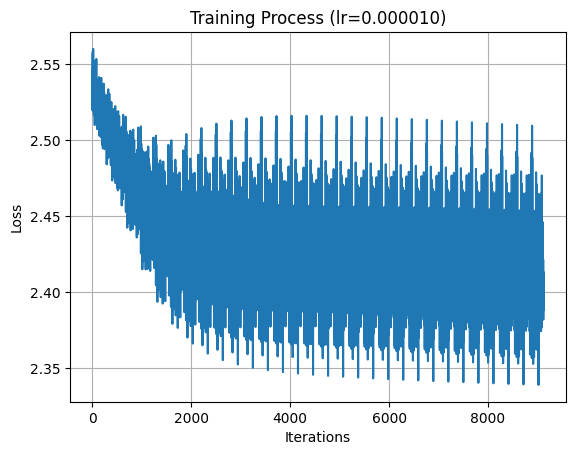

In [147]:
plt.title('Training Process (lr=%f)' % learning_rate)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(train_loss)

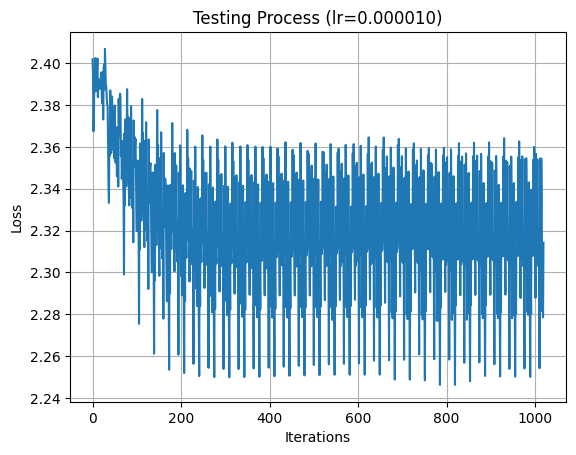

In [148]:
plt.title('Testing Process (lr=%f)' % learning_rate)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(test_loss)

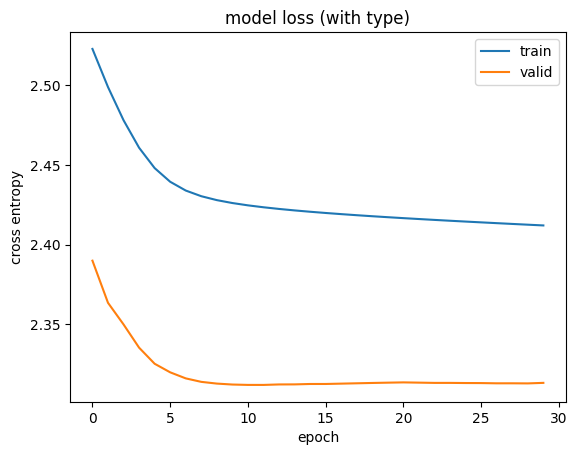

In [164]:
plt.plot(epoch_train_loss)
plt.plot(epoch_test_loss)
plt.title('model loss (with type)')
plt.ylabel('cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Предсказание на тестовой выборке

In [126]:
new = list()
with open("emp_test.jsonl", "r") as g:
    dialogs = g.readlines()
    for dialog in dialogs:
        dialog = json.loads(dialog)
        if len(dialog['dialog']) == 1:
            continue
        new.append(dialog)

In [128]:
new_dataloader = DataLoader(new, batch_size=32, shuffle=False, collate_fn=collate_test)

In [150]:
new_preds = {'change_type': list(), 'top_p': list(), 'top_k': list(), 'typical_p': list(), 'temperature': list()}

for tokenized in tqdm(new_dataloader):

    tokenized = tokenized.to(device)

    with torch.no_grad():
        model_output = model(**tokenized)

        context_embedding = pool(model_output.last_hidden_state, tokenized.attention_mask)

        pred_change_type, pred_top_p, pred_typical_p, pred_top_k, pred_temp = classifier(context_embedding)

    new_preds['change_type'].append(pred_change_type.argmax(-1).cpu().numpy())
    new_preds['top_p'].append(pred_top_p.argmax(-1).cpu().numpy())
    new_preds['top_k'].append(pred_top_k.argmax(-1).cpu().numpy())
    new_preds['typical_p'].append(pred_typical_p.argmax(-1).cpu().numpy())
    new_preds['temperature'].append(pred_temp.argmax(-1).cpu().numpy())

  0%|          | 0/220 [00:00<?, ?it/s]

In [152]:
data = pd.DataFrame(new)

In [153]:
data['change_type'] = np.concatenate(new_preds['change_type'])
data['top_p'] = np.concatenate(new_preds['top_p'])
data['top_k'] = np.concatenate(new_preds['top_k'])
data['typical_p'] = np.concatenate(new_preds['typical_p'])
data['temperature'] = np.concatenate(new_preds['temperature'])
data['do_sample'] = True

In [154]:
top_k_range = [5, 25, 50, 75, 100, 150, 250, 350, 500, 750, 1000]

top_p_range = np.arange(0.05, 1.01, 0.05)

typical_p_range = top_p_range

temperature_range = np.arange(0.05, 1.21, 0.05)

In [155]:
top_p_vocab = {round(value, 2): i for i, value in zip(top_p_range, range(len(top_p_range)))}
typical_p_vocab = {round(value, 2): i for i, value in zip(typical_p_range, range(len(typical_p_range)))}
top_k_vocab = {round(value, 2): i for i, value in zip(top_k_range, range(len(top_k_range)))}
temperature_vocab = {round(value, 2): i for i, value in zip(temperature_range, range(len(temperature_range)))}

In [156]:
data['top_p'] = data['top_p'].map(top_p_vocab)
data['top_k'] = data['top_k'].map(top_k_vocab)
data['typical_p'] = data['typical_p'].map(typical_p_vocab)
data['temperature'] = data['temperature'].map(temperature_vocab)

In [157]:
columns = ['top_p', 'top_k', 'typical_p', 'temperature', 'do_sample']
data['pred_params'] = data[columns].to_dict(orient='records')
data = data.drop(columns=columns)

In [158]:
data = data.drop(columns=['predicted_answers'])

In [159]:
data.head()

,dialog,real_answer,change_type,pred_params
0,[I can't believe the bottom of the bag ripped ...,Even worse. I'm so sorry. What did you do inst...,1,"{'top_p': 0.8, 'top_k': 500, 'typical_p': 1.0,..."
1,"[Two years ago I got diagnosed with MS, What'd...","Well,I pray you get through it",1,"{'top_p': 0.8, 'top_k': 500, 'typical_p': 1.0,..."
2,[I feel very protective of the new dog I got i...,None,1,"{'top_p': 0.8, 'top_k': 500, 'typical_p': 1.0,..."
3,[I took my co-workers phone charger and brough...,Thats sickening. Don't steal stuff or you dese...,1,"{'top_p': 0.8, 'top_k': 500, 'typical_p': 1.0,..."
4,[I have a big exam coming up. I have attended ...,I feel like it. I am going to get together wit...,1,"{'top_p': 0.9000000000000001, 'top_k': 350, 't..."


In [160]:
data.pred_params.astype('str').value_counts()

pred_params
{'top_p': 0.8, 'top_k': 500, 'typical_p': 1.0, 'temperature': 1.2000000000000002, 'do_sample': True}                   4688
{'top_p': 0.7000000000000001, 'top_k': 500, 'typical_p': 1.0, 'temperature': 1.0, 'do_sample': True}                   1277
{'top_p': 0.9000000000000001, 'top_k': 350, 'typical_p': 1.0, 'temperature': 1.2000000000000002, 'do_sample': True}    1061
Name: count, dtype: int64

In [161]:
data.change_type.value_counts()

change_type
1    7026
Name: count, dtype: int64

In [162]:
data[['dialog', 'pred_params']].to_json('final_embedded_pred_params_with_type.jsonl', orient='records', lines=True)